
# Классификация деревом принятия решений

In [13]:
from cgtnnlib.datasets import datasets

datasets

In [14]:
from sklearn import tree

model = tree.DecisionTreeClassifier()
model

DecisionTreeClassifier()

In [15]:
dataset = datasets[1]
print('Target:', dataset.target)
train_df = dataset.data.train_df
test_df = dataset.data.test_df
test_target = test_df[dataset.target]
test_df = test_df.drop(dataset.target, axis=1)
X = train_df.drop(dataset.target, axis=1, inplace=False)
y = train_df[dataset.target]

(X, y)

Target: class


(      buying  maint  doors  persons  lug_boot  safety
 55         3      3      4        2         0       1
 1142       1      1      4        2         2       2
 363        3      0      3        4         1       0
 264        3      1      3        6         1       0
 1449       0      2      3        6         0       0
 ...      ...    ...    ...      ...       ...     ...
 367        3      0      3        4         2       1
 554        2      2      2        4         1       2
 1482       0      2      4        6         2       0
 537        2      3      5        6         2       0
 1112       1      1      3        2         1       2
 
 [1382 rows x 6 columns],
 55      0
 1142    0
 363     0
 264     0
 1449    0
        ..
 367     1
 554     1
 1482    0
 537     0
 1112    0
 Name: class, Length: 1382, dtype: int64)

In [16]:
model.fit(X, y)

DecisionTreeClassifier()

In [17]:
def percent(fraction: float) -> str:
    return f'{fraction * 100:.2f}%'

In [18]:
y_pred = model.predict(test_df)
score = model.score(test_df, test_target)
diff = y_pred - test_target
missclassified_count = diff[diff != 0].count()
correct_count = len(y_pred) - missclassified_count

print(f'Total: {correct_count}/{len(y_pred)} ({percent(score)})')
print(f'Predicted values:\n{y_pred}')
print(f'Actual values:\n{test_target.values}')
print(f'Diff: {diff.values}')

Total: 339/346 (97.98%)
Predicted values:
[0 0 0 1 0 1 0 0 0 0 0 3 0 1 0 0 2 0 0 0 1 0 0 3 0 1 0 0 0 2 2 1 0 2 0 2 1
 1 0 0 0 0 1 1 0 0 0 0 0 0 0 2 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 3 0 1 0 0 0 0 0 0 0 3 1 1 0 0 0 0 0 0 0 0 1 1 1 0 2 1 0 1 0 0 3 1
 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 0 2 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 2 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 2 1 1 1 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1
 2 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 3 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 3 0 0 0 0 3 1 1 0 0 1 0 0 1 3 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 2 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 3 0 2 1 0 1
 0 1 0 1 0 0 0 0 0 0 0 1 0]
Actual values:
[0 0 0 1 0 1 0 0 0 0 0 3 0 1 0 0 2 0 0 0 1 0 0 3 0 1 0 0 0 2 2 1 0 2 0 2 1
 1 0 0 0 0 1 1 0 0 0 0 0 0 0 2 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 3 0 1 0 0 0 0 0 0 0 3 1 1 0 0 0 0 0 0 0 0 1 2 1 0 2 1 0 1 0 0 3 1
 0 0 0 0 0 0 0 

In [19]:
model.get_depth()

12

In [20]:
model.get_n_leaves()

77

In [21]:
model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

In [22]:
dataset.data.df.columns.drop(dataset.target)

Index(['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'], dtype='object')

digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname="Times New Roman"] ;
graph [ranksep=equally, splines=polyline] ;
edge [fontname="Times New Roman"] ;
0 [label=<node &#35;0<br/>safety &le; 0.5<br/>gini = 0.460602<br/>samples = 100.0%<br/>value = [0.69754, 0.222865, 0.039797, 0.039797]<br/>class = foo>, fillcolor="#efb286"] ;
1 [label=<node &#35;1<br/>gini = 0.0<br/>samples = 33.4%<br/>value = [1.0, 0.0, 0.0, 0.0]<br/>class = foo>, fillcolor="#e58139"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label=<node &#35;2<br/>persons &le; 3.0<br/>gini = 0.582757<br/>samples = 66.6%<br/>value = [0.546145, 0.334419, 0.059718, 0.059718]<br/>class = foo>, fillcolor="#f7d7c0"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
3 [label=<node &#35;3<br/>gini = 0.0<br/>samples = 21.9%<br/>value = [1.0, 0.0, 0.0, 0.0]<br/>class = foo>, fillcolor="#e58139"] ;
2 -> 3 ;
4 [label=<node &#35;4<br/>buying &le; 1.5<br/>gini = 0.631042<br/>sa

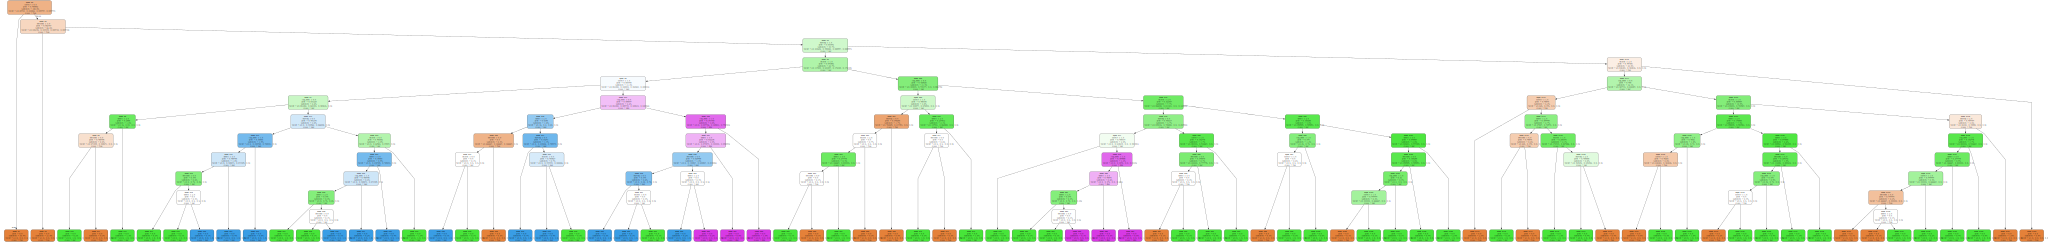

In [23]:

import graphviz

graphviz_source = tree.export_graphviz(
    decision_tree=model,
    feature_names=dataset.data.df.columns.drop(dataset.target),
    class_names=['foo', 'bar', 'baz', 'qux'],
    filled=True,
    leaves_parallel=True,
    node_ids=True,
    proportion=True,
    # rotate=True,
    rounded=True,
    special_characters=True,
    precision=6, # digits after point
    fontname='Times New Roman',
    # fontname='Big Caslon',
    # fontname='Brush Script MT',
)
print(graphviz_source)
graphviz.Source(graphviz_source)

# Визуализация

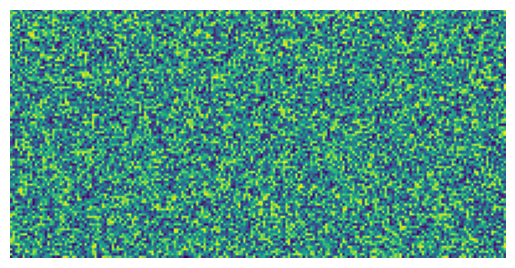

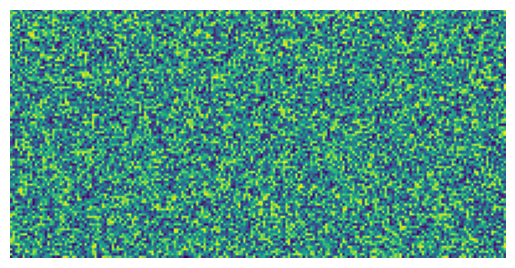

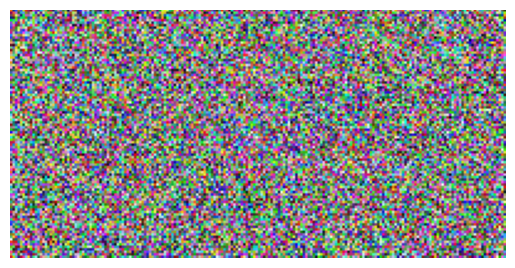

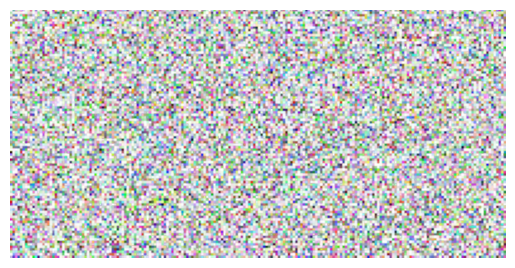

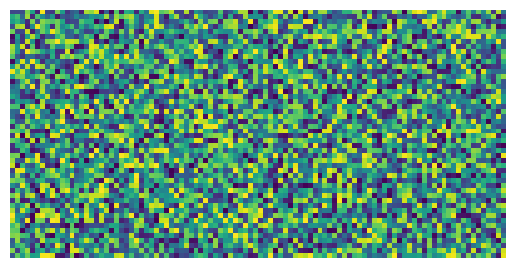

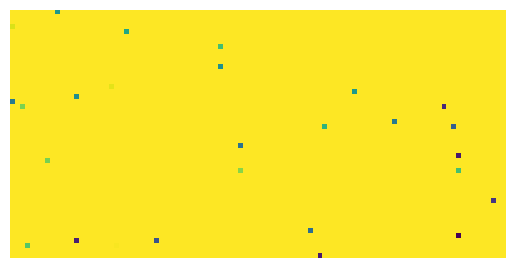

/var/folders/m9/y193wddj505gjbgjyvhjmzjm0000gq/T/ipykernel_13714/3503685528.py:25: RuntimeWarning: invalid value encountered in cast
  array = (array * 255).astype(np.uint8)  # Convert to uint8 for PIL


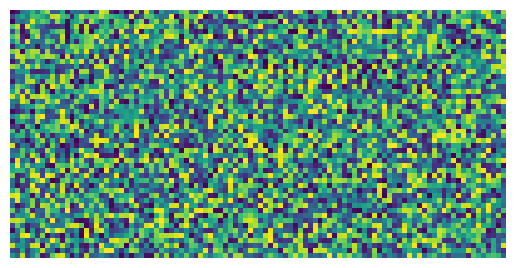

In [26]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt  # Optional: for inline display using matplotlib

MODE_LUMINANCE = 'L'
MODE_RGB = 'RGB'
MODE_RGBA = 'RGBA'
COLORMAP_VIRIDIS = 'viridis'

def visualize_array_with_pillow(array, colormap=None):
    """
    Visualizes a NumPy array as an image using Pillow.

    Args:
        array:  A NumPy array representing the image data.
                - It can be a 2D array (grayscale) or a 3D array (RGB or RGBA).
                - The data type should typically be uint8 (0-255) or float32/64 (0.0-1.0).
        color_map: (Optional) Colormap to use for grayscale images.
              If None (default) grayscale images are displayed directly.
              You can specify a matplotlib colormap name like 'viridis', 'magma', 'gray', etc.
    """

    if array.dtype == np.float32 or array.dtype == np.float64:
        array = np.clip(array, 0.0, 1.0)
        array = (array * 255).astype(np.uint8)  # Convert to uint8 for PIL
    elif array.dtype != np.uint8:
        print("Warning: Array data type is not uint8 or float.  Attempting to scale to uint8.")
        try:
            array = ((array - array.min()) / (array.max() - array.min()) * 255).astype(np.uint8)
        except ValueError:
            print("Error: Array contains NaN values or all values are the same. Cannot normalize.  Returning.")
            return

    if len(array.shape) == 2:
        mode = MODE_LUMINANCE
        if colormap:
            plt.imshow(array, cmap=colormap)
            plt.axis('off')
            plt.show()
            return
    elif len(array.shape) == 3:
        if array.shape[2] == 3:  # RGB
            mode = MODE_RGB
        elif array.shape[2] == 4:  # RGBA
            mode = MODE_RGBA
        else:
            raise ValueError("Array must have 2 (grayscale) or 3/4 (RGB/RGBA) channels.")
    else:
        raise ValueError("Array must be 2D or 3D.")

    image = Image.fromarray(array, mode=mode)

    plt.imshow(image)
    plt.axis('off')
    plt.show()


# Example Usage
# 1. Grayscale Example
gray_array = np.random.randint(0, 256, size=(100, 200), dtype=np.uint8)
visualize_array_with_pillow(gray_array)
visualize_array_with_pillow(gray_array, colormap=COLORMAP_VIRIDIS)

# 2. RGB Example
rgb_array = np.random.randint(0, 256, size=(100, 200, 3), dtype=np.uint8)
visualize_array_with_pillow(rgb_array)

# 3. RGBA Example (with transparency)
rgba_array = np.random.randint(0, 256, size=(100, 200, 4), dtype=np.uint8)
visualize_array_with_pillow(rgba_array)

# 4. Float array example
float_array = np.random.rand(50, 100) # values from 0.0 to 1.0
visualize_array_with_pillow(float_array)

# 5. Float array with larger values
float_array2 = np.random.rand(50, 100) * 255.0  # Values from 0.0 to 255.0
visualize_array_with_pillow(float_array2) # Will need to be scaled.

# 6. Array with NaN values
nan_array = np.random.rand(50, 100)
nan_array[0,0] = np.nan #Introduce NaN
visualize_array_with_pillow(nan_array) #Handles the nan value and prints an error message.

# Сравнение с обычным дропаутом